In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve

In [2]:
train_data = pd.read_csv('training.csv', sep=',', )
test_data = pd.read_csv('test.csv', sep=',')

In [3]:
print(train_data.shape)
print(test_data.shape)

(95662, 16)
(45019, 15)


In [4]:
train_data['TransactionStartTime'].tail()

95657    2019-02-13T09:54:09Z
95658    2019-02-13T09:54:25Z
95659    2019-02-13T09:54:35Z
95660    2019-02-13T10:01:10Z
95661    2019-02-13T10:01:28Z
Name: TransactionStartTime, dtype: object

In [6]:
test_data['TransactionStartTime'].head()

0    2019-02-13T10:01:40Z
1    2019-02-13T10:02:12Z
2    2019-02-13T10:02:30Z
3    2019-02-13T10:02:38Z
4    2019-02-13T10:02:58Z
Name: TransactionStartTime, dtype: object

In [4]:
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

In [5]:
print(train_data.shape)
print(test_data.shape)

(95662, 16)
(45019, 15)


In [6]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [7]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [8]:
count_train_acc = train_data.groupby('AccountId', as_index=False)['CustomerId'].count().rename(columns={'CustomerId' : 'No. Customers per Acc'}).reset_index(drop=True)
count_test_acc = test_data.groupby('AccountId', as_index=False)['CustomerId'].count().rename(columns={'CustomerId' : 'No. Customers per Acc'}).reset_index(drop=True)

In [9]:
count_train_acc['No. Customers per Acc'].sum()

95662

In [10]:
count_train_acc.head(3)

,AccountId,No. Customers per Acc
0,AccountId_1,3
1,AccountId_10,965
2,AccountId_100,2


In [11]:
train_data = pd.merge(train_data, count_train_acc, on='AccountId', how='left')
test_data = pd.merge(test_data, count_test_acc, on='AccountId', how='left')

In [12]:
train_data.drop(['CurrencyCode', 'CountryCode'], axis=1, inplace=True)
test_data.drop(['CurrencyCode', 'CountryCode'], axis=1, inplace=True)

In [13]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,No. Customers per Acc
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,66
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,30893
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,2
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,26
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,30893


In [14]:
train_data[(train_data['Amount']<0) & (train_data['Amount']<=train_data['Value'])].shape

(38189, 15)

In [15]:
def amount_value(data):
    amount = data[0]
    value = data[1]
    
    
    if amount >= 0:
        return value - np.abs(amount)
    elif amount < 0:
        return (-value-amount)
    
train_data['ExtraCharges'] = train_data[['Amount', 'Value']].apply(amount_value, axis=1)
test_data['ExtraCharges'] = test_data[['Amount', 'Value']].apply(amount_value, axis=1)

In [16]:
train_data.corr()

,Amount,Value,PricingStrategy,FraudResult,No. Customers per Acc,ExtraCharges
Amount,1.000000,0.989692,-0.061931,0.557370,-0.047126,0.058267
Value,0.989692,1.000000,-0.017020,0.566739,-0.049609,0.056616
PricingStrategy,-0.061931,-0.017020,1.000000,-0.033821,-0.214033,-0.050254
FraudResult,0.557370,0.566739,-0.033821,1.000000,-0.031484,0.158483
No. Customers per Acc,-0.047126,-0.049609,-0.214033,-0.031484,1.000000,-0.061586
ExtraCharges,0.058267,0.056616,-0.050254,0.158483,-0.061586,1.000000


In [17]:
train_data.drop('Value', axis=1, inplace=True)
test_data.drop('Value', axis=1, inplace=True)

In [18]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult',
       'No. Customers per Acc', 'ExtraCharges'],
      dtype='object')

In [19]:
def get_year(trans_time):
    yr = trans_time.split('T')[0].split('-')[0]
    return yr

train_data['Year'] = train_data['TransactionStartTime'].map(get_year)
test_data['Year'] = test_data['TransactionStartTime'].map(get_year)

In [20]:
def get_month(trans_time):
    month = trans_time.split('T')[0].split('-')[1]
    
    if month == '11':
        return 'November'
    elif month == '12':
        return 'December'
    elif month == '01':
        return 'January'
    elif month == '02':
        return 'February'
    elif month == '03':
        return 'March'
    
train_data['Month'] = train_data['TransactionStartTime'].map(get_month)
test_data['Month'] = test_data['TransactionStartTime'].map(get_month)

In [21]:
from datetime import datetime
import calendar


def get_weekday(trans_time):
    yr = trans_time.split('T')[0].split('-')[0]
    month = trans_time.split('T')[0].split('-')[1]
    day = trans_time.split('T')[0].split('-')[2]
    
    date = datetime(year=int(yr), month=int(month), day=int(day))
    return calendar.day_name[date.weekday()]

train_data['Weekday'] = train_data['TransactionStartTime'].map(get_weekday)
test_data['Weekday'] = test_data['TransactionStartTime'].map(get_weekday)

In [22]:
#date.weekday(date(2018, 12, 25))

In [23]:
def get_hour(trans_time):
    hr = trans_time.split('T')[1].split(':')[0]
    return hr

train_data['Hour'] = train_data['TransactionStartTime'].map(get_hour)
test_data['Hour'] = test_data['TransactionStartTime'].map(get_hour)

In [24]:
def weekend_weekday(day):
    if day not in ['Saturday', 'Saturday']:
        return 'Weekday'
    else:
        return 'Weekend'
    
train_data['Weekday/Weekend'] = train_data['Weekday'].map(weekend_weekday)
test_data['Weekday/Weekend'] = test_data['Weekday'].map(weekend_weekday)

In [25]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,TransactionStartTime,PricingStrategy,FraudResult,No. Customers per Acc,ExtraCharges,Year,Month,Weekday,Hour,Weekday/Weekend
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,2018-11-15T02:18:49Z,2,0,66,0.0,2018,November,Thursday,02,Weekday
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,2018-11-15T02:19:08Z,2,0,30893,0.0,2018,November,Thursday,02,Weekday
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,2018-11-15T02:44:21Z,2,0,2,0.0,2018,November,Thursday,02,Weekday
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,2018-11-15T03:32:55Z,2,0,26,1800.0,2018,November,Thursday,03,Weekday
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,2018-11-15T03:34:21Z,2,0,30893,0.0,2018,November,Thursday,03,Weekday


In [26]:
from datetime import datetime
import calendar


def is_holiday(trans_time):
    yr = int(trans_time.split('T')[0].split('-')[0])
    month = int(trans_time.split('T')[0].split('-')[1])
    day = int(trans_time.split('T')[0].split('-')[2])
    
    if (
        ((yr==2018) & (month==12) & (day==25)) or (
        (yr==2018) & (month==12) & (day==26)) or (
        (yr==2019) & (month==1) & (yr==1)) or (
        (yr==2019) & (month==1) & (day==26)) or (
        (yr==2019) & (month==2) & (day==16)) or (
        (yr==2019) & (month==3) & (day==8)) or (
        (yr==2019) & (month==3) & (day==30))
    ):
        
        return 'Yes'
    else:
        return 'No'
    
    

train_data['Holiday'] = train_data['TransactionStartTime'].map(is_holiday)
test_data['Holiday'] = test_data['TransactionStartTime'].map(is_holiday)

In [27]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,PricingStrategy,FraudResult,No. Customers per Acc,ExtraCharges,Year,Month,Weekday,Hour,Weekday/Weekend,Holiday
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,2,0,66,0.0,2018,November,Thursday,02,Weekday,No
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,2,0,30893,0.0,2018,November,Thursday,02,Weekday,No
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,2,0,2,0.0,2018,November,Thursday,02,Weekday,No
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,2,0,26,1800.0,2018,November,Thursday,03,Weekday,No
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,2,0,30893,0.0,2018,November,Thursday,03,Weekday,No


In [28]:
min([1,])

1

In [29]:
from datetime import date




def days_to_nearest(trans_time):
    d0 = date(2018, 12, 25)
    d1 = date(2018, 12, 26)
    d2 = date(2019, 1, 1)
    d3 = date(2019, 1, 26)
    d4 = date(2019, 2, 16)
    d5 = date(2019, 3, 8)
    d6 = date(2019, 3, 30)

    holidays = [d0, d1, d2, d3, d4, d5, d6]

    yr = int(trans_time.split('T')[0].split('-')[0])
    month = int(trans_time.split('T')[0].split('-')[1])
    day = int(trans_time.split('T')[0].split('-')[2])

    day = date(yr, month, day)
    diff = []
    
    for hol in holidays:
        d_new = hol - day
        if d_new.days >=0:
            diff.append(d_new.days)
        else:
            continue
        
    return min(diff)
        
    

train_data['Days_to_Nearest_Holiday'] = train_data['TransactionStartTime'].map(days_to_nearest)
test_data['Days_to_Nearest_Holiday'] = test_data['TransactionStartTime'].map(days_to_nearest)

In [30]:
train_data.corr()

,Amount,PricingStrategy,FraudResult,No. Customers per Acc,ExtraCharges,Days_to_Nearest_Holiday
Amount,1.000000,-0.061931,0.557370,-0.047126,0.058267,-0.008470
PricingStrategy,-0.061931,1.000000,-0.033821,-0.214033,-0.050254,0.069137
FraudResult,0.557370,-0.033821,1.000000,-0.031484,0.158483,-0.004631
No. Customers per Acc,-0.047126,-0.214033,-0.031484,1.000000,-0.061586,-0.010920
ExtraCharges,0.058267,-0.050254,0.158483,-0.061586,1.000000,0.004555
Days_to_Nearest_Holiday,-0.008470,0.069137,-0.004631,-0.010920,0.004555,1.000000


In [31]:
train_data.head(3)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,FraudResult,No. Customers per Acc,ExtraCharges,Year,Month,Weekday,Hour,Weekday/Weekend,Holiday,Days_to_Nearest_Holiday
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,0,66,0.0,2018,November,Thursday,02,Weekday,No,40
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,0,30893,0.0,2018,November,Thursday,02,Weekday,No,40
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,0,2,0.0,2018,November,Thursday,02,Weekday,No,40


In [32]:
#train_data['Prev_Amt'] = (train_data.groupby('CustomerId')['Amount'].shift()).reset_index(drop=True)
#train_data['Prev_Amt'] = train_data['Prev_Amt'].fillna(train_data['Prev_Amt'].median())

#test_data['Prev_Amt'] = (test_data.groupby('CustomerId')['Amount'].shift()).reset_index(drop=True)
#test_data['Prev_Amt'] = test_data['Prev_Amt'].fillna(test_data['Prev_Amt'].median())

In [33]:
#test_data['Prev_Amt'].dtype

In [34]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,FraudResult,No. Customers per Acc,ExtraCharges,Year,Month,Weekday,Hour,Weekday/Weekend,Holiday,Days_to_Nearest_Holiday
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,0,66,0.0,2018,November,Thursday,02,Weekday,No,40
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,0,30893,0.0,2018,November,Thursday,02,Weekday,No,40
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,0,2,0.0,2018,November,Thursday,02,Weekday,No,40
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,0,26,1800.0,2018,November,Thursday,03,Weekday,No,40
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,0,30893,0.0,2018,November,Thursday,03,Weekday,No,40


In [35]:
train_data.groupby('CustomerId')['Amount']

In [36]:
def time_trans(trans_time):
    time = trans_time.split('T')
    date = time[0]
    time = time[1].split('Z')[0]
    time = date + ' ' + time
    return pd.to_datetime(time)


train_data['Time'] = train_data['TransactionStartTime'].map(time_trans)
test_data['Time'] = test_data['TransactionStartTime'].map(time_trans)

In [37]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,No. Customers per Acc,ExtraCharges,Year,Month,Weekday,Hour,Weekday/Weekend,Holiday,Days_to_Nearest_Holiday,Time
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,66,0.0,2018,November,Thursday,02,Weekday,No,40,2018-11-15 02:18:49
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,30893,0.0,2018,November,Thursday,02,Weekday,No,40,2018-11-15 02:19:08
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,2,0.0,2018,November,Thursday,02,Weekday,No,40,2018-11-15 02:44:21
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,26,1800.0,2018,November,Thursday,03,Weekday,No,40,2018-11-15 03:32:55
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,30893,0.0,2018,November,Thursday,03,Weekday,No,40,2018-11-15 03:34:21


In [38]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [40]:
train_data['Prev_Amt'] = (train_data.groupby('CustomerId')['Amount'].shift()).reset_index(drop=True)
train_data['Prev_Amt'] = train_data['Prev_Amt'].fillna(train_data['Prev_Amt'].median())

test_data['Prev_Amt'] = (test_data.groupby('CustomerId')['Amount'].shift()).reset_index(drop=True)
test_data['Prev_Amt'] = test_data['Prev_Amt'].fillna(test_data['Prev_Amt'].median())

In [41]:
train_data.groupby('CustomerId')['Prev_Amt'].mean()

CustomerId
CustomerId_1                 NaN
CustomerId_10                NaN
CustomerId_1001      3700.000000
CustomerId_1002       427.500000
CustomerId_1003      3700.000000
CustomerId_1004              NaN
CustomerId_1005      6125.000000
CustomerId_1006              NaN
CustomerId_1007              NaN
CustomerId_1008     10000.000000
CustomerId_1009              NaN
CustomerId_1010      4396.333333
CustomerId_1012      1714.465753
CustomerId_1014    108982.857143
CustomerId_1016      3500.000000
CustomerId_1020      1443.539604
CustomerId_1021              NaN
CustomerId_1022              NaN
CustomerId_1025      1158.333333
CustomerId_1027      2063.076923
CustomerId_1028              NaN
CustomerId_1029      6312.500000
CustomerId_1030       264.285714
CustomerId_1031      2159.975510
CustomerId_1032      1000.000000
CustomerId_1033      1000.000000
CustomerId_1034      2633.866667
CustomerId_1036       475.000000
CustomerId_1038      3500.000000
CustomerId_1039      8565.344828

In [40]:
x = train_data.groupby('CustomerId')['Time'].diff()
train_data['Time_since_last_trans'] = x/(np.timedelta64(1, 'm'))
train_data['Time_since_last_trans'] = train_data['Time_since_last_trans'].fillna(train_data['Time_since_last_trans'].median())


y = test_data.groupby('CustomerId')['Time'].diff()
test_data['Time_since_last_trans'] = y/(np.timedelta64(1, 'm'))
test_data['Time_since_last_trans'] = test_data['Time_since_last_trans'].fillna(test_data['Time_since_last_trans'].median())

In [41]:
import datetime

def last_one_week(time):
    date = time - datetime.timedelta(days=7)
    date = date.strftime('%Y-%m-%d*%H:%M:%S').split('*')
    date = date[0]
    pst_wk = datetime.datetime.strptime(date, '%Y-%m-%d')
    return pst_wk.date()


train_data['Past_one_Week'] = train_data['Time'].map(last_one_week)
test_data['Past_one_Week'] = test_data['Time'].map(last_one_week)

In [42]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,Month,Weekday,Hour,Weekday/Weekend,Holiday,Days_to_Nearest_Holiday,Time,Prev_Amt,Time_since_last_trans,Past_one_Week
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,November,Thursday,02,Weekday,No,40,2018-11-15 02:18:49,1000.0,2.200000,2018-11-08
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,November,Thursday,02,Weekday,No,40,2018-11-15 02:19:08,1000.0,0.316667,2018-11-08
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,November,Thursday,02,Weekday,No,40,2018-11-15 02:44:21,1000.0,2.200000,2018-11-08
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,November,Thursday,03,Weekday,No,40,2018-11-15 03:32:55,1000.0,2.200000,2018-11-08
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,November,Thursday,03,Weekday,No,40,2018-11-15 03:34:21,20000.0,1.433333,2018-11-08


In [43]:
def credit_debit(amount):
    if amount < 0:
        return 'Credit'
    elif amount > 0:
        return 'Debit'
    
train_data['Form'] = train_data['Amount'].map(credit_debit)
test_data['Form'] = test_data['Amount'].map(credit_debit)

In [44]:
import datetime

def get_date(time):
    date = time.strftime('%Y-%m-%d*%H:%M:%S').split('*')
    date = date[0]
    pst_wk = datetime.datetime.strptime(date, '%Y-%m-%d')
    return pd.to_datetime(pst_wk.date())


train_data['Date'] = train_data['Time'].map(get_date)
test_data['Date'] = test_data['Time'].map(get_date)

In [45]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,Hour,Weekday/Weekend,Holiday,Days_to_Nearest_Holiday,Time,Prev_Amt,Time_since_last_trans,Past_one_Week,Form,Date
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,02,Weekday,No,40,2018-11-15 02:18:49,1000.0,2.200000,2018-11-08,Debit,2018-11-15
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,02,Weekday,No,40,2018-11-15 02:19:08,1000.0,0.316667,2018-11-08,Credit,2018-11-15
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,02,Weekday,No,40,2018-11-15 02:44:21,1000.0,2.200000,2018-11-08,Debit,2018-11-15
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,03,Weekday,No,40,2018-11-15 03:32:55,1000.0,2.200000,2018-11-08,Debit,2018-11-15
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,03,Weekday,No,40,2018-11-15 03:34:21,20000.0,1.433333,2018-11-08,Credit,2018-11-15


In [46]:
train_data['Date'].dtype

dtype('<M8[ns]')

In [47]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,Hour,Weekday/Weekend,Holiday,Days_to_Nearest_Holiday,Time,Prev_Amt,Time_since_last_trans,Past_one_Week,Form,Date
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,02,Weekday,No,40,2018-11-15 02:18:49,1000.0,2.200000,2018-11-08,Debit,2018-11-15
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,02,Weekday,No,40,2018-11-15 02:19:08,1000.0,0.316667,2018-11-08,Credit,2018-11-15
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,02,Weekday,No,40,2018-11-15 02:44:21,1000.0,2.200000,2018-11-08,Debit,2018-11-15
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,03,Weekday,No,40,2018-11-15 03:32:55,1000.0,2.200000,2018-11-08,Debit,2018-11-15
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,03,Weekday,No,40,2018-11-15 03:34:21,20000.0,1.433333,2018-11-08,Credit,2018-11-15


In [48]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult',
       'No. Customers per Acc', 'ExtraCharges', 'Year', 'Month', 'Weekday',
       'Hour', 'Weekday/Weekend', 'Holiday', 'Days_to_Nearest_Holiday', 'Time',
       'Prev_Amt', 'Time_since_last_trans', 'Past_one_Week', 'Form', 'Date'],
      dtype='object')

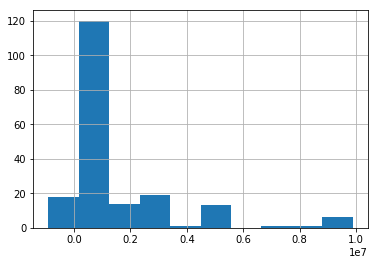

In [49]:
train_data[train_data.FraudResult==1]['Amount'].hist()

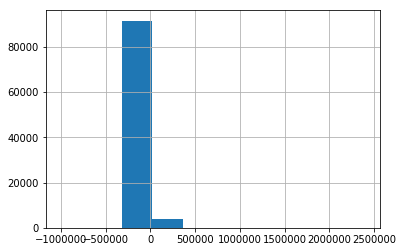

In [50]:
train_data[train_data.FraudResult==0]['Amount'].hist()

In [51]:
train_data[(train_data.FraudResult==1) & (train_data.Amount<0)]['Amount'].values

array([-900000., -500000., -500000., -500000.,   -1005.])

In [52]:
train_data[(train_data.FraudResult==0) & (train_data.Amount<0)]['Amount'].values

array([  -20.,  -644.,  -500., ..., -1000.,   -20.,   -60.])

In [53]:
train_data[train_data.Amount>2400000]['FraudResult'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [54]:
def suspicious(df):
    amt, productId, productCat, channelId, providerId = df[0], df[1], df[2], df[3], df[4]
    
    if amt > 2400000:
        if (productId=='ProductId_15') & (productCat=='financial_services') & (channelId=='ChannelId_3') & (providerId in ['ProviderId_1', 'ProviderId_3', 'ProviderId_5']):
            return 'Very Suspicious'
        else:
            return 'Suspicious'
    else:
        return 'Non-Suspicious'

train_data['Suspicious'] = train_data[['Amount', 'ProductId', 'ProductCategory', 'ChannelId', 'ProviderId']].apply(suspicious, axis=1)
test_data['Suspicious'] = test_data[['Amount', 'ProductId', 'ProductCategory', 'ChannelId', 'ProviderId']].apply(suspicious, axis=1)

In [55]:
train_data['Suspicious']

0        Non-Suspicious
1        Non-Suspicious
2        Non-Suspicious
3        Non-Suspicious
4        Non-Suspicious
5        Non-Suspicious
6        Non-Suspicious
7        Non-Suspicious
8        Non-Suspicious
9        Non-Suspicious
10       Non-Suspicious
11       Non-Suspicious
12       Non-Suspicious
13       Non-Suspicious
14       Non-Suspicious
15       Non-Suspicious
16       Non-Suspicious
17       Non-Suspicious
18       Non-Suspicious
19       Non-Suspicious
20       Non-Suspicious
21       Non-Suspicious
22       Non-Suspicious
23       Non-Suspicious
24       Non-Suspicious
25       Non-Suspicious
26       Non-Suspicious
27       Non-Suspicious
28       Non-Suspicious
29       Non-Suspicious
              ...      
95632    Non-Suspicious
95633    Non-Suspicious
95634    Non-Suspicious
95635    Non-Suspicious
95636    Non-Suspicious
95637    Non-Suspicious
95638    Non-Suspicious
95639    Non-Suspicious
95640    Non-Suspicious
95641    Non-Suspicious
95642    Non-Sus

In [56]:
train_data[(train_data.Amount<0) & (train_data.FraudResult==1)]['Amount'].values

array([-900000., -500000., -500000., -500000.,   -1005.])

In [57]:
(train_data[(train_data.Amount<-100000) & (train_data.FraudResult==0)]['Amount']).describe()

count         25.000000
mean     -221000.000000
std       237385.937522
min     -1000000.000000
25%      -200000.000000
50%      -150000.000000
75%      -115000.000000
max      -110000.000000
Name: Amount, dtype: float64

In [58]:
(train_data[(train_data.Amount<0) & (train_data.FraudResult==1)][['ProductCategory', 'ProductId', 'ChannelId', 'ProviderId', 'Amount']])

,ProductCategory,ProductId,ChannelId,ProviderId,Amount
55822,airtime,ProductId_3,ChannelId_2,ProviderId_4,-900000.0
55841,airtime,ProductId_10,ChannelId_2,ProviderId_4,-500000.0
56035,airtime,ProductId_3,ChannelId_2,ProviderId_4,-500000.0
60834,airtime,ProductId_3,ChannelId_2,ProviderId_4,-500000.0
68918,financial_services,ProductId_6,ChannelId_2,ProviderId_4,-1005.0


In [59]:
#train_data[(train_data.Amount <0) & (train_data['ProductCategory']=='airtime') & (train_data['ProductId'] == 'ProductId_3') & (train_data['ProviderId']=='ProviderId_4') & (train_data['ChannelId']=='ChannelId_2') & (train_data.FraudResult==0)]['Amount']

In [60]:
train_data[(train_data.Amount <0) & (train_data['ProductCategory']=='airtime') & (train_data['ProductId'] == 'ProductId_3') & (train_data['ProviderId']=='ProviderId_4') & (train_data['ChannelId']=='ChannelId_2') & (train_data.FraudResult==0)]['Amount'].max()

-500.0

In [61]:
train_data[(train_data.Amount >=-950000) & (train_data.Amount <=-500000) & (train_data['ProductCategory']=='airtime') & (train_data['ProductId'] == 'ProductId_10') & (train_data['ProviderId']=='ProviderId_4') & (train_data['ChannelId']=='ChannelId_2')]['FraudResult']

55841    1
Name: FraudResult, dtype: int64

In [62]:
#test_data[(test_data.Amount <=-0) & (test_data['ProductCategory']=='airtime') & (test_data['ProductId'] == 'ProductId_10') & (test_data['ProviderId']=='ProviderId_4') & (test_data['ChannelId']=='ChannelId_2')][['ProductCategory', 'ProductId', 'ChannelId', 'ProviderId', 'Amount']]

In [63]:
train_data[(train_data.Amount <0) & (train_data['ProductCategory']=='airtime') & (train_data['ProductId'] == 'ProductId_3') & (train_data['ProviderId']=='ProviderId_4') & (train_data['ChannelId']=='ChannelId_2') & (train_data.FraudResult==1)]['Amount'].max()

-500000.0

In [64]:
train_data[train_data.Amount<=-200000]['FraudResult'].value_counts()

0    10
1     4
Name: FraudResult, dtype: int64

In [65]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,Weekday/Weekend,Holiday,Days_to_Nearest_Holiday,Time,Prev_Amt,Time_since_last_trans,Past_one_Week,Form,Date,Suspicious
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,Weekday,No,40,2018-11-15 02:18:49,1000.0,2.200000,2018-11-08,Debit,2018-11-15,Non-Suspicious
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,Weekday,No,40,2018-11-15 02:19:08,1000.0,0.316667,2018-11-08,Credit,2018-11-15,Non-Suspicious
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,Weekday,No,40,2018-11-15 02:44:21,1000.0,2.200000,2018-11-08,Debit,2018-11-15,Non-Suspicious
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,Weekday,No,40,2018-11-15 03:32:55,1000.0,2.200000,2018-11-08,Debit,2018-11-15,Non-Suspicious
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,Weekday,No,40,2018-11-15 03:34:21,20000.0,1.433333,2018-11-08,Credit,2018-11-15,Non-Suspicious


In [66]:
train_data[train_data.CustomerId=='CustomerId_1002']['Amount']

647      1500.0
649       -75.0
5835      500.0
5837      -25.0
21276    1000.0
21277     -50.0
22407     500.0
22408     -25.0
61845    1000.0
61847     -50.0
63423     -50.0
Name: Amount, dtype: float64

In [67]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult',
       'No. Customers per Acc', 'ExtraCharges', 'Year', 'Month', 'Weekday',
       'Hour', 'Weekday/Weekend', 'Holiday', 'Days_to_Nearest_Holiday', 'Time',
       'Prev_Amt', 'Time_since_last_trans', 'Past_one_Week', 'Form', 'Date',
       'Suspicious'],
      dtype='object')

In [68]:
test_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'TransactionStartTime', 'PricingStrategy', 'No. Customers per Acc',
       'ExtraCharges', 'Year', 'Month', 'Weekday', 'Hour', 'Weekday/Weekend',
       'Holiday', 'Days_to_Nearest_Holiday', 'Time', 'Prev_Amt',
       'Time_since_last_trans', 'Past_one_Week', 'Form', 'Date', 'Suspicious'],
      dtype='object')

In [69]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,Weekday/Weekend,Holiday,Days_to_Nearest_Holiday,Time,Prev_Amt,Time_since_last_trans,Past_one_Week,Form,Date,Suspicious
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,Weekday,No,40,2018-11-15 02:18:49,1000.0,2.200000,2018-11-08,Debit,2018-11-15,Non-Suspicious
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,Weekday,No,40,2018-11-15 02:19:08,1000.0,0.316667,2018-11-08,Credit,2018-11-15,Non-Suspicious
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,Weekday,No,40,2018-11-15 02:44:21,1000.0,2.200000,2018-11-08,Debit,2018-11-15,Non-Suspicious
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,Weekday,No,40,2018-11-15 03:32:55,1000.0,2.200000,2018-11-08,Debit,2018-11-15,Non-Suspicious
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,Weekday,No,40,2018-11-15 03:34:21,20000.0,1.433333,2018-11-08,Credit,2018-11-15,Non-Suspicious


In [70]:
len(test_data.columns)

28

In [170]:
#features = ['ProviderId', 'ProductCategory', 'ProductCategory', 'ChannelId', 'PricingStrategy']
#time_frame = ['7d', '10d', '14d', '21d', '30d']


#train_df = [train_data]
#test_df = [test_data]


#train = train_data.set_index('Time')
#test = test_data.set_index('Time')


#for feat in features:
#    for t in time_frame:
#        #train = train_data.set_index('Time')
#        #test = test_data.set_index('Time')
        
#        group_train = train.groupby(['CustomerId', feat]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
#        group_train = group_train.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}ays'.format(feat,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}ays'.format(feat,t), 'max' : 'max_amt_per_{}_in_last_{}ays'.format(feat,t), 'count' : 'no_of_trans_per_{}_in_last_{}ays'.format(feat,t)})
        
#        group_test = test.groupby(['CustomerId', feat]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
#        group_test = group_test.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}ays'.format(feat,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}ays'.format(feat,t), 'max' : 'max_amt_per_{}_in_last_{}ays'.format(feat,t), 'count' : 'no_of_trans_per_{}_in_last_{}ays'.format(feat,t)})
        
        #train_df.append(group_train)
        #test_df.append(group_test)

#        train = train_data.merge(group_train, on=['CustomerId', feat, 'Time'], how='left')
#        test = test_data.merge(group_test, on=['CustomerId', feat, 'Time'], how='left')

In [71]:
from functools import reduce

In [97]:
x = train_data.set_index('Time').groupby('CustomerId').rolling('168h')['Amount'].mean().rename('K').reset_index()\


In [98]:
x[x.CustomerId=='CustomerId_4406']['K'].head()

64517    1000.0
64518     490.0
64519     660.0
64520     490.0
64521     592.0
Name: K, dtype: float64

In [99]:
train_data[train_data.CustomerId=='CustomerId_4406'][['Time', 'Amount']]

,Time,Amount
0,2018-11-15 02:18:49,1000.0
1,2018-11-15 02:19:08,-20.0
1492,2018-11-16 12:44:49,1000.0
1493,2018-11-16 12:45:02,-20.0
1645,2018-11-16 14:20:12,1000.0
1646,2018-11-16 14:20:25,-20.0
2387,2018-11-17 09:44:15,2000.0
2414,2018-11-17 10:34:28,500.0
2498,2018-11-17 13:43:24,1000.0
2845,2018-11-18 08:54:58,1500.0


In [100]:
#--------------------ProviderId-------------------------

time_frame = ['12h', '24h', '72h', '168h']

train = train_data.set_index('Time')
test = test_data.set_index('Time')

df_train_a = [train_data]
df_test_a = [test_data]

a = 'ProviderId'

for t in time_frame:
    #train = train_data.set_index('Time')
    #test = test_data.set_index('Time')
        
    group_train = train.groupby(['CustomerId', a]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_train = group_train.reset_index().drop_duplicates(subset=['CustomerId', a, 'Time'])
    group_train = group_train.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(a,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(a,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(a,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(a,t)})
        
    group_test = test.groupby(['CustomerId', a]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_test = group_test.reset_index().drop_duplicates(subset=['CustomerId', a, 'Time'])
    group_test = group_test.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(a,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(a,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(a,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(a,t)})
    
    
       
    
    
    df_train_a.append(group_train)
    df_test_a.append(group_test)
    
train_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', a, 'Time'], how='left'), df_train_a)
test_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', a, 'Time'], how='left'), df_test_a)

In [101]:
#train_data.shape
test_data.shape

(45019, 44)

In [102]:
#--------------------ProductCategory-------------------------

time_frame = ['12h', '24h', '72h', '168h']

train = train_data.set_index('Time')
test = test_data.set_index('Time')

df_train_b = [train_data]
df_test_b = [test_data]

b = 'ProductCategory'

for t in time_frame:
    #train = train_data.set_index('Time')
    #test = test_data.set_index('Time')
        
    group_train = train.groupby(['CustomerId', b]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_train = group_train.reset_index().drop_duplicates(subset=['CustomerId', b, 'Time'])
    group_train = group_train.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(b,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(b,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(b,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(b,t)})
        
    group_test = test.groupby(['CustomerId', b]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_test = group_test.reset_index().drop_duplicates(subset=['CustomerId', b, 'Time'])
    group_test = group_test.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(b,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(b,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(b,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(b,t)})
    
    
       
    
    
    df_train_b.append(group_train)
    df_test_b.append(group_test)
    
train_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', b, 'Time'], how='left'), df_train_b)
test_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', b, 'Time'], how='left'), df_test_b)

In [175]:
train_data.shape
test_data.shape

(45019, 60)

In [103]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,max_amt_per_ProductCategory_in_last_24hhrs,no_of_trans_per_ProductCategory_in_last_24hhrs,Avg_amt_per_ProductCategory_in_last_72hhrs,sum_of_amt_per_ProductCategory_in_last_72hhrs,max_amt_per_ProductCategory_in_last_72hhrs,no_of_trans_per_ProductCategory_in_last_72hhrs,Avg_amt_per_ProductCategory_in_last_168hhrs,sum_of_amt_per_ProductCategory_in_last_168hhrs,max_amt_per_ProductCategory_in_last_168hhrs,no_of_trans_per_ProductCategory_in_last_168hhrs
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,1000.0,1.0,1000.0,1000.0,1000.0,1.0,1000.0,1000.0,1000.0,1.0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,-20.0,1.0,-20.0,-20.0,-20.0,1.0,-20.0,-20.0,-20.0,1.0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,500.0,1.0,500.0,500.0,500.0,1.0,500.0,500.0,500.0,1.0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,20000.0,1.0,20000.0,20000.0,20000.0,1.0,20000.0,20000.0,20000.0,1.0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,-644.0,1.0,-644.0,-644.0,-644.0,1.0,-644.0,-644.0,-644.0,1.0


In [104]:
#--------------------ChannelId-------------------------

time_frame = ['12h', '24h', '72h', '168h']

train = train_data.set_index('Time')
test = test_data.set_index('Time')

df_train_c = [train_data]
df_test_c = [test_data]

c = 'ChannelId'

for t in time_frame:
    #train = train_data.set_index('Time')
    #test = test_data.set_index('Time')
        
    group_train = train.groupby(['CustomerId', c]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_train = group_train.reset_index().drop_duplicates(subset=['CustomerId', c, 'Time'])
    group_train = group_train.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(c,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(c,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(c,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(c,t)})
        
    group_test = test.groupby(['CustomerId', c]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_test = group_test.reset_index().drop_duplicates(subset=['CustomerId', c, 'Time'])
    group_test = group_test.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(c,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(c,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(c,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(c,t)})
    
    
       
    
    
    df_train_c.append(group_train)
    df_test_c.append(group_test)
    
train_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', c, 'Time'], how='left'), df_train_c)
test_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', c, 'Time'], how='left'), df_test_c)

In [105]:
train_data.shape
test_data.shape

(45019, 76)

In [106]:
#--------------------ProductId-------------------------

time_frame = ['12h', '24h', '72h', '168h']

train = train_data.set_index('Time')
test = test_data.set_index('Time')

df_train_d = [train_data]
df_test_d = [test_data]

d = 'ProductId'

for t in time_frame:
    #train = train_data.set_index('Time')
    #test = test_data.set_index('Time')
        
    group_train = train.groupby(['CustomerId', d]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_train = group_train.reset_index().drop_duplicates(subset=['CustomerId', d, 'Time'])
    group_train = group_train.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(d,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(d,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(d,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(d,t)})
        
    group_test = test.groupby(['CustomerId', d]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_test = group_test.reset_index().drop_duplicates(subset=['CustomerId', d, 'Time'])
    group_test = group_test.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(d,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(d,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(d,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(d,t)})
    
    
       
    
    
    df_train_d.append(group_train)
    df_test_d.append(group_test)
    
train_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', d, 'Time'], how='left'), df_train_d)
test_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', d, 'Time'], how='left'), df_test_d)

In [107]:
train_data.shape
test_data.shape

(45019, 92)

In [108]:
#--------------------PricingStrategy-------------------------

time_frame = ['12h', '24h', '72h', '168h']

train = train_data.set_index('Time')
test = test_data.set_index('Time')

df_train_e = [train_data]
df_test_e = [test_data]

e = 'PricingStrategy'

for t in time_frame:
    #train = train_data.set_index('Time')
    #test = test_data.set_index('Time')
        
    group_train = train.groupby(['CustomerId', e]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_train = group_train.reset_index().drop_duplicates(subset=['CustomerId', e, 'Time'])
    group_train = group_train.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(e,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(e,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(e,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(e,t)})
        
    group_test = test.groupby(['CustomerId', e]).rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_test = group_test.reset_index().drop_duplicates(subset=['CustomerId', e, 'Time'])
    group_test = group_test.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(e,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(e,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(e,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(e,t)})
    
    
       
    
    
    df_train_e.append(group_train)
    df_test_e.append(group_test)
    
train_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', e, 'Time'], how='left'), df_train_e)
test_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', e, 'Time'], how='left'), df_test_e)

In [109]:
train_data.shape

(95662, 109)

In [110]:
#--------------------CustomerId_Analysis-------------------------

time_frame = ['12h', '24h', '72h', '168h']

train = train_data.set_index('Time')
test = test_data.set_index('Time')

df_train_f = [train_data]
df_test_f = [test_data]

f = 'CustomerId'

for t in time_frame:
    #train = train_data.set_index('Time')
    #test = test_data.set_index('Time')
        
    group_train = train.groupby('CustomerId').rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_train = group_train.reset_index().drop_duplicates(subset=['CustomerId', 'Time'])
    group_train = group_train.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(f,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(f,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(f,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(f,t)})
        
    group_test = test.groupby('CustomerId').rolling(t).Amount.agg(['mean', 'sum', 'max', 'count'])
    group_test = group_test.reset_index().drop_duplicates(subset=['CustomerId', 'Time'])
    group_test = group_test.rename(columns={'mean' : 'Avg_amt_per_{}_in_last_{}hrs'.format(f,t), 'sum' : 'sum_of_amt_per_{}_in_last_{}hrs'.format(f,t), 'max' : 'max_amt_per_{}_in_last_{}hrs'.format(f,t), 'count' : 'no_of_trans_per_{}_in_last_{}hrs'.format(f,t)})
    
    
       
    
    
    df_train_f.append(group_train)
    df_test_f.append(group_test)
    
train_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', 'Time'], how='left'), df_train_f)
test_data = reduce(lambda left, right: pd.merge(left, right, on=['CustomerId', 'Time'], how='left'), df_test_f)

In [111]:
train_data.shape
test_data.shape

(45019, 124)

In [112]:
#train_data.corrwith(train_data.FraudResult)

In [113]:
train_data['SubscriptionId'].nunique()

3627

In [114]:
train_data['CustomerId'].nunique()

3742

In [115]:
train_data['AccountId'].nunique()

3633

In [116]:
train_data[train_data.CustomerId=='CustomerId_988']['SubscriptionId'].unique()

array(['SubscriptionId_2185', 'SubscriptionId_3829',
       'SubscriptionId_4346'], dtype=object)

In [117]:
femi_train = train_data.groupby('CustomerId')['SubscriptionId'].nunique()
femi_train = femi_train.reset_index().drop_duplicates(subset='CustomerId').rename(columns={'SubscriptionId':'No_of_unique_subscription_per_customer'})

femi_test = test_data.groupby('CustomerId')['SubscriptionId'].nunique()
femi_test = femi_test.reset_index().drop_duplicates(subset='CustomerId').rename(columns={'SubscriptionId':'No_of_unique_subscription_per_customer'})

In [118]:
femi_train_2 = train_data.groupby('AccountId')['SubscriptionId'].nunique()
femi_train_2 = femi_train_2.reset_index().drop_duplicates(subset='AccountId').rename(columns={'SubscriptionId':'No_of_unique_subscription_per_acc'})

femi_test_2 = test_data.groupby('AccountId')['SubscriptionId'].nunique()
femi_test_2 = femi_test_2.reset_index().drop_duplicates(subset='AccountId').rename(columns={'SubscriptionId':'No_of_unique_subscription_per_acc'})

In [119]:
train_data = pd.merge(train_data, femi_train, on='CustomerId', how='left')
test_data = pd.merge(test_data, femi_test, on='CustomerId', how='left')

train_data = pd.merge(train_data, femi_train_2, on='AccountId', how='left')
test_data = pd.merge(test_data, femi_test_2, on='AccountId', how='left')

In [120]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,Avg_amt_per_CustomerId_in_last_72hhrs,sum_of_amt_per_CustomerId_in_last_72hhrs,max_amt_per_CustomerId_in_last_72hhrs,no_of_trans_per_CustomerId_in_last_72hhrs,Avg_amt_per_CustomerId_in_last_168hhrs,sum_of_amt_per_CustomerId_in_last_168hhrs,max_amt_per_CustomerId_in_last_168hhrs,no_of_trans_per_CustomerId_in_last_168hhrs,No_of_unique_subscription_per_customer,No_of_unique_subscription_per_acc
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,1000.0,1000.0,1000.0,1.0,1000.0,1000.0,1000.0,1.0,3,1
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,490.0,980.0,1000.0,2.0,490.0,980.0,1000.0,2.0,3,2
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,500.0,500.0,500.0,1.0,500.0,500.0,500.0,1.0,1,1
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,20000.0,20000.0,20000.0,1.0,20000.0,20000.0,20000.0,1.0,3,1
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,9678.0,19356.0,20000.0,2.0,9678.0,19356.0,20000.0,2.0,3,2


In [121]:
def multiple_sub(no_of_sub):
    if no_of_sub > 1:
        return 'Yes'
    else:
        return 'No'
    
train_data['Multiple_Sub_by_Customer'] = train_data['No_of_unique_subscription_per_customer'].map(multiple_sub)
test_data['Multiple_Sub_by_Customer'] = test_data['No_of_unique_subscription_per_customer'].map(multiple_sub)



train_data['Multiple_Sub_by_Acc'] = train_data['No_of_unique_subscription_per_acc'].map(multiple_sub)
test_data['Multiple_Sub_by_Acc'] = test_data['No_of_unique_subscription_per_acc'].map(multiple_sub)

In [122]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,...,max_amt_per_CustomerId_in_last_72hhrs,no_of_trans_per_CustomerId_in_last_72hhrs,Avg_amt_per_CustomerId_in_last_168hhrs,sum_of_amt_per_CustomerId_in_last_168hhrs,max_amt_per_CustomerId_in_last_168hhrs,no_of_trans_per_CustomerId_in_last_168hhrs,No_of_unique_subscription_per_customer,No_of_unique_subscription_per_acc,Multiple_Sub_by_Customer,Multiple_Sub_by_Acc
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,...,1000.0,1.0,1000.0,1000.0,1000.0,1.0,3,1,Yes,No
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,...,1000.0,2.0,490.0,980.0,1000.0,2.0,3,2,Yes,Yes
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,...,500.0,1.0,500.0,500.0,500.0,1.0,1,1,No,No
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,...,20000.0,1.0,20000.0,20000.0,20000.0,1.0,3,1,Yes,No
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,...,20000.0,2.0,9678.0,19356.0,20000.0,2.0,3,2,Yes,Yes


In [123]:
train_data.shape

(95662, 129)

In [124]:
test_data.shape

(45019, 128)

In [125]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       ...
       'max_amt_per_CustomerId_in_last_72hhrs',
       'no_of_trans_per_CustomerId_in_last_72hhrs',
       'Avg_amt_per_CustomerId_in_last_168hhrs',
       'sum_of_amt_per_CustomerId_in_last_168hhrs',
       'max_amt_per_CustomerId_in_last_168hhrs',
       'no_of_trans_per_CustomerId_in_last_168hhrs',
       'No_of_unique_subscription_per_customer',
       'No_of_unique_subscription_per_acc', 'Multiple_Sub_by_Customer',
       'Multiple_Sub_by_Acc'],
      dtype='object', length=129)

In [126]:
train_data.to_csv('FeatureEngineeredTrain.csv', index=False)
test_data.to_csv('FeatureEngineeredTest.csv', index=False)